Multiprocessing start method already set to 'spawn'.
Using device: cuda

==================== Data Loading ====================
Loaded 'river_before' from /kaggle/input/dataset-revier/dataset zuixin/river_before.mat, shape: (463, 241, 198), dtype: int16
Loaded 'river_after' from /kaggle/input/dataset-revier/dataset zuixin/river_after.mat, shape: (463, 241, 198), dtype: int16
Loaded 'lakelabel_v1' from /kaggle/input/dataset-revier/dataset zuixin/groundtruth.mat, shape: (463, 241), dtype: uint8
Determined number of bands: 198
Initial shapes - Before: torch.Size([463, 241, 198]), After: torch.Size([463, 241, 198]), GT: torch.Size([463, 241])
GT Unique Values: tensor([  0., 255.])

==================== Preprocessing ====================
Normalizing tensor with shape: (463, 241, 198)
Normalization complete. Output range: 0.0000 - 1.0000
Normalizing tensor with shape: (463, 241, 198)
Normalization complete. Output range: 0.0000 - 1.0000
Ground truth binarized. Unique values: tensor([0., 1.])

<ipython-input-4-e4d22e3cfe96>:513: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=device))


Training history plot saved to training_history.png


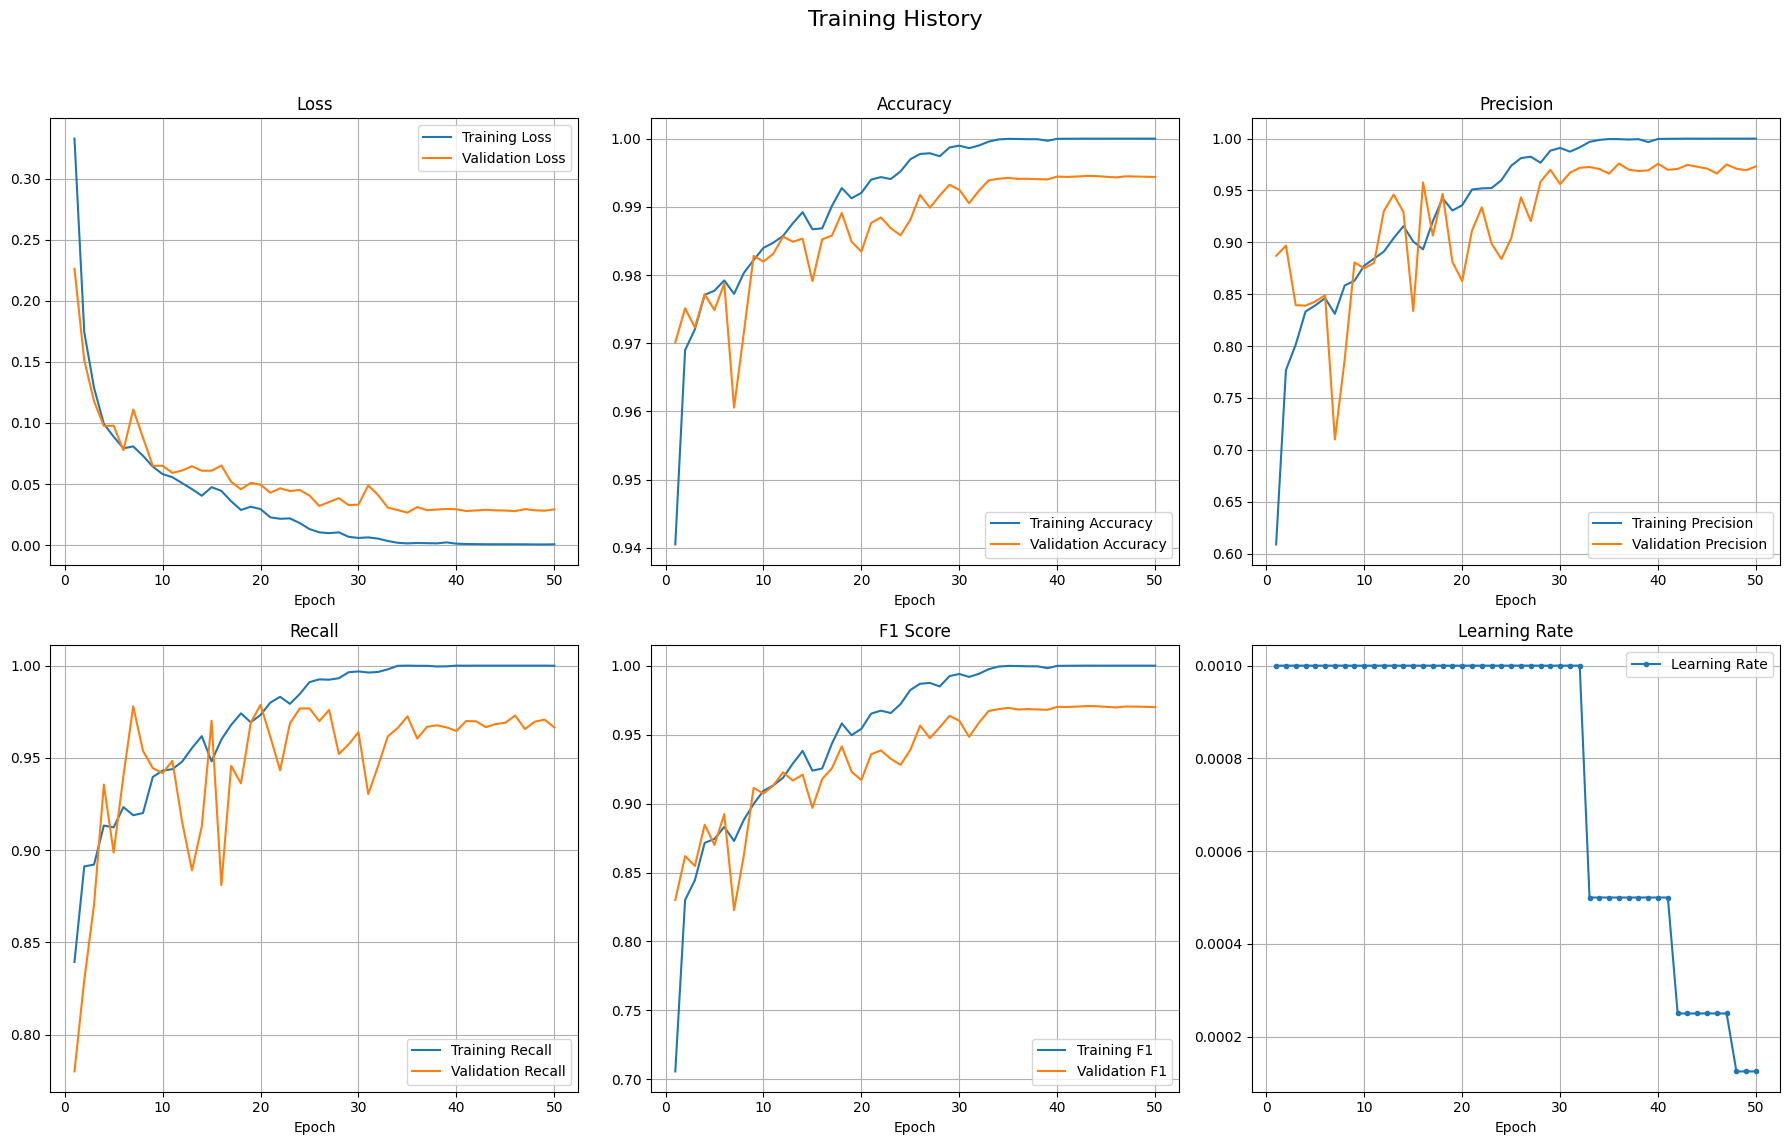

==================== Model Training Complete ====================

==================== Evaluating on Test Set ====================
Test Loss: 0.0255
Test Accuracy: 0.9945
Test Precision: 0.9642
Test Recall: 0.9720
Test F1 Score: 0.9681
Test confusion matrix saved to checkpoints/test_confusion_matrix.png


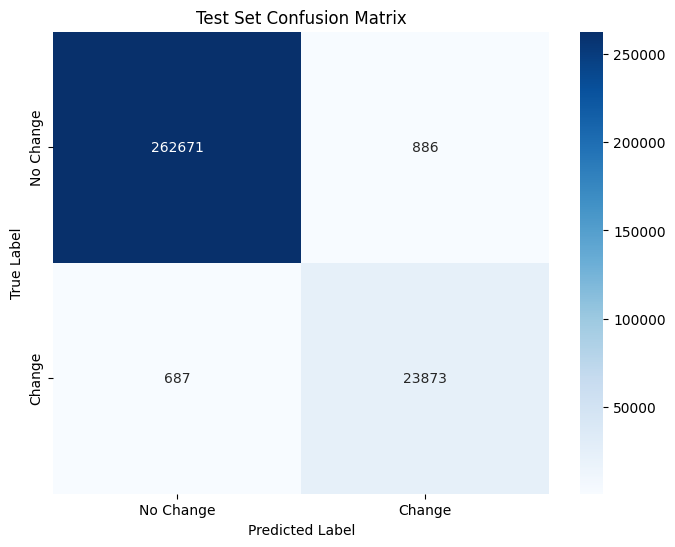

==================== Evaluation Complete ====================

==================== Full Image Prediction ====================
Moving full processed images to device for prediction/visualization...
Predicting full image with 11856 patches (Patch: 9x9, Stride: 3)...
  Processed batch 9 / 93
  Processed batch 18 / 93
  Processed batch 27 / 93
  Processed batch 36 / 93
  Processed batch 45 / 93
  Processed batch 54 / 93
  Processed batch 63 / 93
  Processed batch 72 / 93
  Processed batch 81 / 93
  Processed batch 90 / 93
Full image prediction complete.
Full image comparison saved to checkpoints/improved_full_image_comparison.png


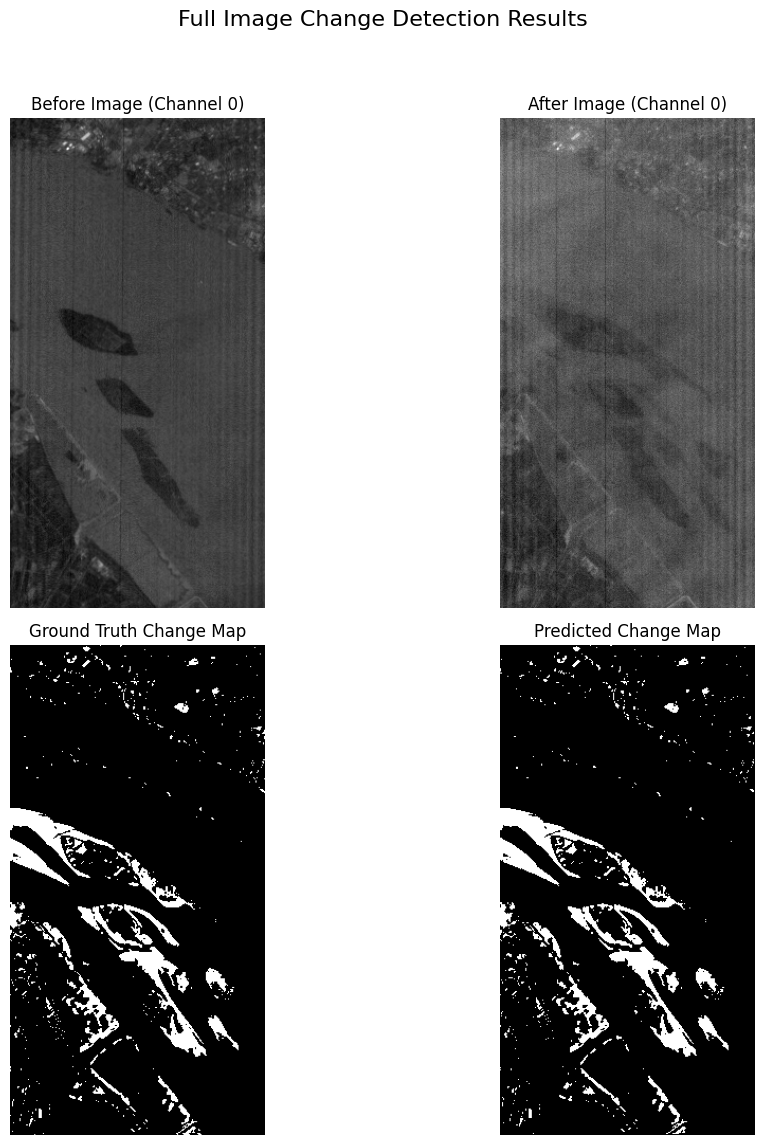


==================== Full Image Metrics ====================
Full Image Accuracy: 0.9983
Full Image Precision: 0.9911
Full Image Recall: 0.9896
Full Image F1 Score: 0.9904

==================== Visualizing Sample Predictions ====================
Sample predictions visualization saved to checkpoints/sample_predictions.png


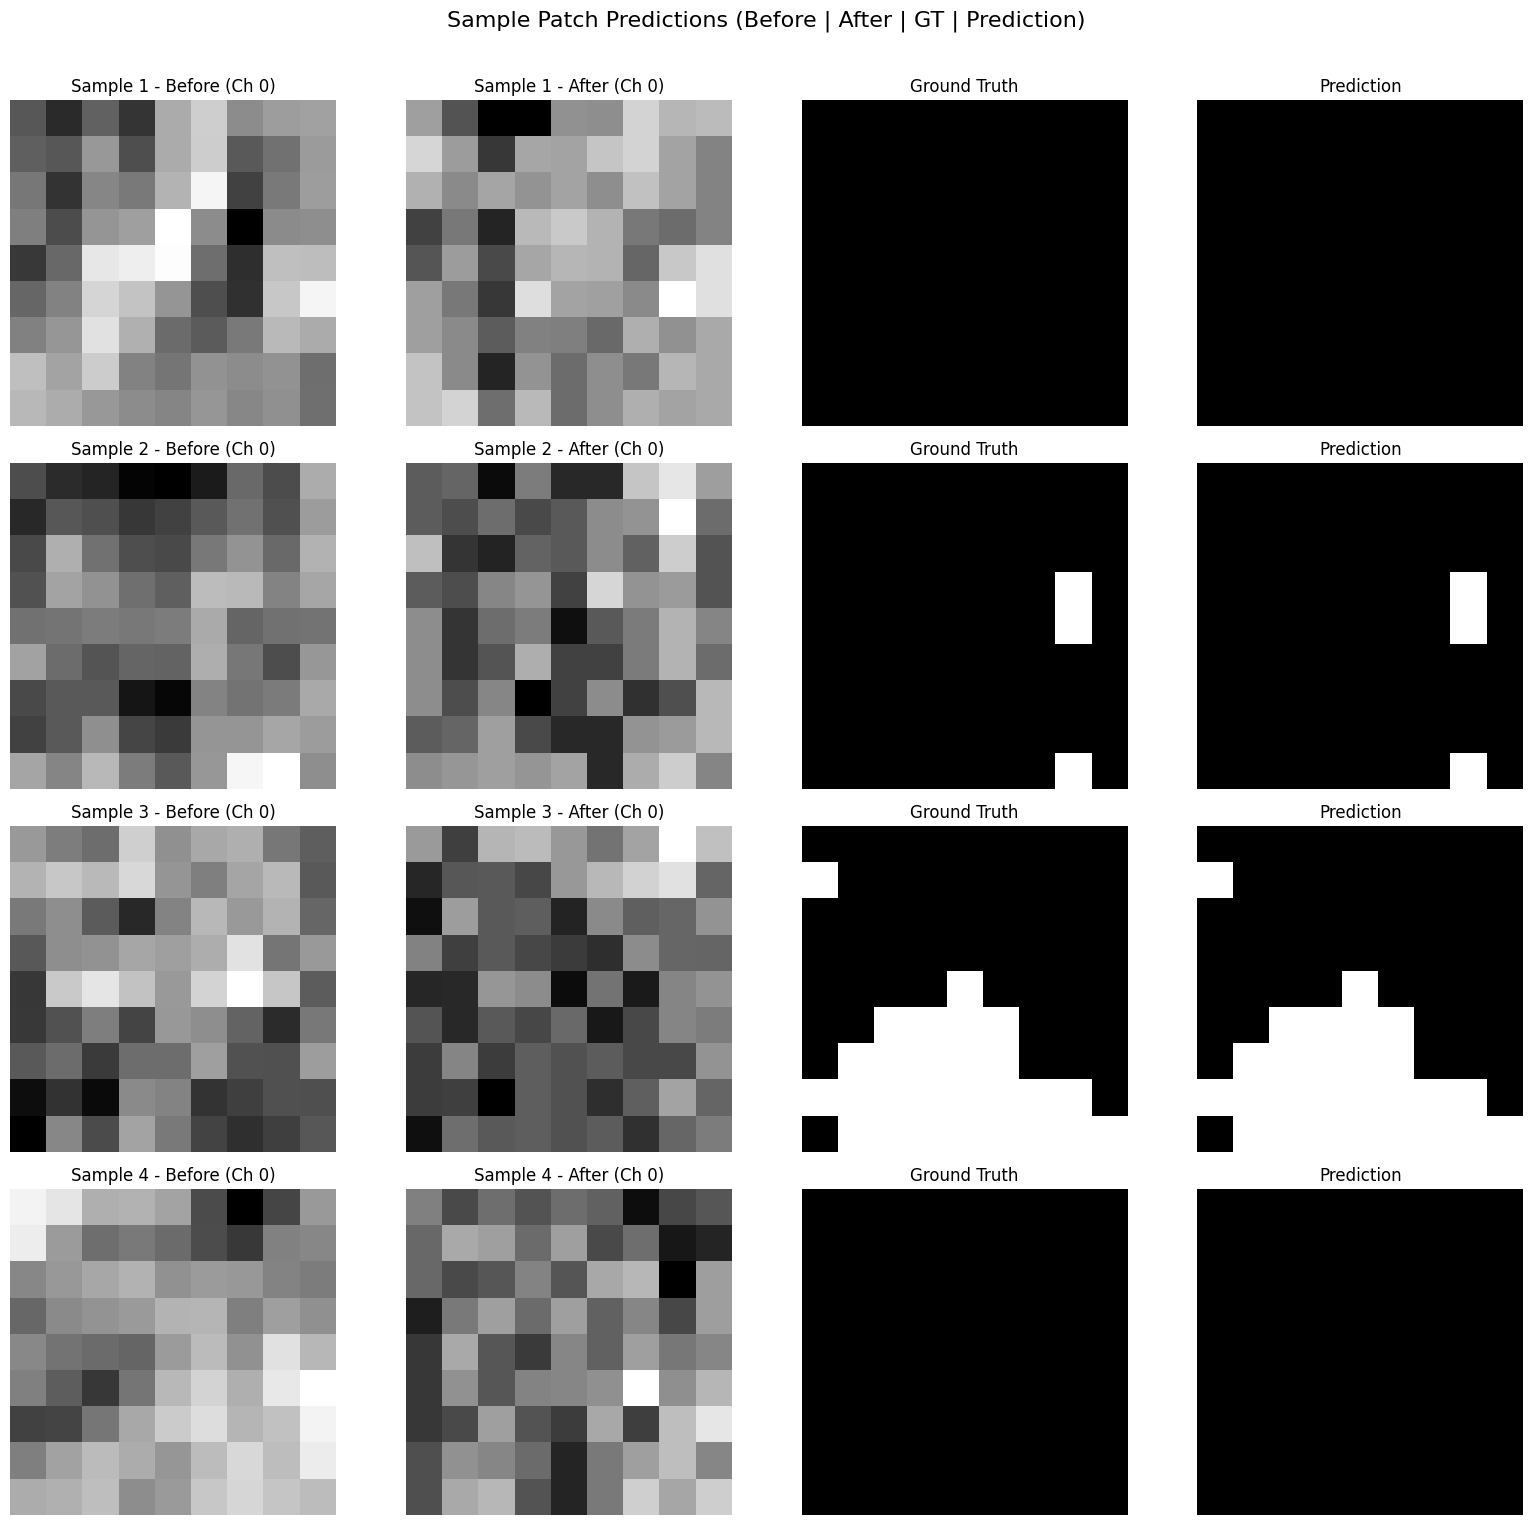


Script finished successfully.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.multiprocessing as mp # Import multiprocessing

from scipy.io import loadmat
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os # Keep os if needed elsewhere, otherwise Path from pathlib is often sufficient

# --- Configuration ---
BASE_DATA_PATH = Path('/kaggle/input/dataset-revier/dataset zuixin')
SAVE_MODEL_PATH = Path('checkpoints')
BEFORE_FILE = 'river_before.mat'
AFTER_FILE = 'river_after.mat'
GT_FILE = 'groundtruth.mat'
BEST_MODEL_NAME = 'best_model.pth'
TRAINING_HISTORY_PLOT = 'training_history.png'
FULL_IMAGE_COMPARISON_PLOT = 'improved_full_image_comparison.png'
SAMPLE_PREDICTIONS_PLOT = 'sample_predictions.png'
TEST_CONFUSION_MATRIX_PLOT = 'test_confusion_matrix.png'

# Data Parameters
# NUM_BANDS = 198 # Determine dynamically after loading if possible
GT_THRESHOLD = 255 # Value in ground truth representing change

# Patch Extraction Parameters
PATCH_SIZE = 9
STRIDE = 3 # stride < patch_size implies overlap

# Training Parameters
TEST_SIZE = 0.3 # 30% for temp_dataset (val + test)
VAL_SIZE = 0.5 # 50% of temp_dataset for validation (15% of total)
RANDOM_STATE = 42
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
SCHEDULER_PATIENCE = 5
SCHEDULER_FACTOR = 0.5
EARLY_STOPPING_PATIENCE = 15
GRADIENT_CLIP_NORM = 1.0
POSITIVE_WEIGHT = 2.0 # For weighted BCE loss
NUM_WORKERS = 2 # Number of workers for DataLoader

# Prediction Parameters
PREDICTION_THRESHOLD = 0.5
# Use same patch size/stride as training for consistency in full prediction
FULL_IMAGE_PREDICT_PATCH_SIZE = PATCH_SIZE
FULL_IMAGE_PREDICT_STRIDE = STRIDE

# Visualization Parameters
NUM_SAMPLE_PREDICTIONS = 4

# --- Data Loading Function ---
def load_mat_data(file_path, variable_name):
    """Loads data from a .mat file."""
    try:
        data = loadmat(file_path)[variable_name]
        print(f"Loaded '{variable_name}' from {file_path}, shape: {data.shape}, dtype: {data.dtype}")
        return torch.tensor(data, dtype=torch.float32)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        exit()
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in {file_path}")
        exit()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        exit()

# --- Preprocessing Function ---
def normalize_per_channel_vectorized(data_tensor):
    """Normalizes each channel of a tensor (H, W, C) to [0, 1] using vectorized operations."""
    if data_tensor.ndim != 3:
        raise ValueError(f"Input tensor must be 3D (H, W, C). Got {data_tensor.ndim}D")
    h, w, n_channels = data_tensor.shape
    print(f"Normalizing tensor with shape: ({h}, {w}, {n_channels})")

    # Reshape to (H*W, C) to easily calculate min/max per channel
    # Use reshape instead of view for flexibility with memory layout
    try:
        data_flat = data_tensor.reshape(-1, n_channels) # <--- Use reshape
    except RuntimeError as e:
        print(f"Error reshaping tensor: {e}. Tensor shape: {data_tensor.shape}")
        # Try making it contiguous first
        data_flat = data_tensor.contiguous().reshape(-1, n_channels)
        print("Reshaped after making tensor contiguous.")


    channel_min = torch.min(data_flat, dim=0)[0] # Shape (C,)
    channel_max = torch.max(data_flat, dim=0)[0] # Shape (C,)

    denom = channel_max - channel_min
    # Avoid division by zero: if min == max, result should be 0 (or constant)
    # Set denominator to 1 where min == max to avoid NaN; the numerator will be 0 anyway.
    denom[denom == 0] = 1.0

    # Use broadcasting: (H, W, C) - (C,) / (C,)
    normalized_data = (data_tensor - channel_min) / denom

    # Clamp to ensure values are strictly within [0, 1] due to potential float inaccuracies
    normalized_data = torch.clamp(normalized_data, 0.0, 1.0)
    print(f"Normalization complete. Output range: {normalized_data.min().item():.4f} - {normalized_data.max().item():.4f}")

    return normalized_data

# --- Patch Extraction Function ---
def extract_patches_with_overlap_original(image, patch_size=PATCH_SIZE, stride=STRIDE):
    """Original patch extraction with loop."""
    patches = []
    if image.ndim != 3:
         raise ValueError(f"Input image must be 3D (C, H, W). Got {image.ndim}D")
    C, H, W = image.shape
    center_offset = patch_size // 2

    if patch_size > H or patch_size > W:
        print(f"Warning: Patch size ({patch_size}) is larger than image dimensions ({H}, {W}). No patches will be extracted.")
        return torch.empty((0, C, patch_size, patch_size), device=image.device)

    print(f"Extracting {patch_size}x{patch_size} patches with stride {stride} from image ({C}, {H}, {W})...")
    # Iterate through potential center pixels based on stride
    for i in range(center_offset, H - center_offset, stride):
        for j in range(center_offset, W - center_offset, stride):
            # Calculate patch boundaries
            top, bottom = i - center_offset, i + center_offset + 1
            left, right = j - center_offset, j + center_offset + 1

            # Extract patch
            patch = image[:, top:bottom, left:right]

            # Ensure patch has the correct size (should always be true with the loop range)
            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                 patches.append(patch)
            # else: # This case should theoretically not happen with the chosen loop range
            #     print(f"Skipping patch at center ({i},{j}) due to unexpected boundary issue. Patch shape: {patch.shape}")

    if not patches:
        print("Warning: No patches extracted. Check image dimensions, patch size, and stride.")
        return torch.empty((0, C, patch_size, patch_size), device=image.device)

    print(f"Extracted {len(patches)} patches.")
    return torch.stack(patches)

# --- Model Definition ---
class ConvBlock(nn.Module):
    """Convolution -> BatchNorm -> ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False) # Bias False common when using BN
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # Inplace saves memory

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class EncoderBlock(nn.Module):
    """Two ConvBlocks followed by MaxPool"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        skip = self.conv2(x) # Output before pooling for skip connection
        pool = self.pool(skip)
        return pool, skip # Return pooled output and skip connection

class DecoderBlock(nn.Module):
    """Upsample -> Concatenate skip -> Two ConvBlocks"""
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        # Upsampling layer (increases H, W by 2), reducing channels appropriately
        # ConvTranspose output channels should match the feature map it needs to produce before concat
        up_out_channels = skip_channels # Often set to match skip connection channels for simple concat
        self.up = nn.ConvTranspose2d(in_channels, up_out_channels, kernel_size=2, stride=2)
        # Convolutions after concatenating upsampled features and skip features
        self.conv1 = ConvBlock(up_out_channels + skip_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)

        # Handle potential size mismatch after ConvTranspose2d and pooling
        # Pad x (upsampled) to match skip's spatial dimensions if necessary
        diff_h = skip.size(2) - x.size(2)
        diff_w = skip.size(3) - x.size(3)

        # Apply padding (left, right, top, bottom)
        # Check if padding is needed
        if diff_h > 0 or diff_w > 0:
             x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                           diff_h // 2, diff_h - diff_h // 2])
        # Handle cases where x might be slightly larger (less common with standard pooling/upsampling)
        elif diff_h < 0 or diff_w < 0:
             # Crop skip tensor instead
             skip = skip[:, :, -diff_h // 2 : skip.size(2) - (-diff_h - -diff_h // 2),
                           -diff_w // 2 : skip.size(3) - (-diff_w - -diff_w // 2)]


        x = torch.cat([skip, x], dim=1) # Concatenate along channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class SiamUNetFusion(nn.Module):
    """Siamese U-Net based model with feature fusion for Change Detection."""
    # Define features list outside __init__ if it's constant or pass as argument
    FEATURES = [64, 128, 256, 512]
    
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        features = self.FEATURES

        # Branch 1 Encoder (e.g., for 'before' image)
        self.enc1_br1 = EncoderBlock(in_channels, features[0])
        self.enc2_br1 = EncoderBlock(features[0], features[1])
        self.enc3_br1 = EncoderBlock(features[1], features[2])

        # Branch 2 Encoder (e.g., for difference image)
        self.enc1_br2 = EncoderBlock(in_channels, features[0])
        self.enc2_br2 = EncoderBlock(features[0], features[1])
        self.enc3_br2 = EncoderBlock(features[1], features[2])

        # Bottleneck (operates on fused pooled features)
        self.bottleneck = ConvBlock(features[2], features[3]) # Input based on single branch output size

        # Decoders (using fused skip connections)
        # Input channels: bottleneck output, fused skip channels, output channels
        self.dec3 = DecoderBlock(features[3], features[2], features[2]) # Skip from enc3 (features[2])
        self.dec2 = DecoderBlock(features[2], features[1], features[1]) # Skip from enc2 (features[1])
        self.dec1 = DecoderBlock(features[1], features[0], features[0]) # Skip from enc1 (features[0])

        # Final output convolution
        self.output_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x1, x2):
        # Calculate difference image *first*
        x_diff = torch.abs(x1 - x2)

        # Branch 1 ('before' image)
        pool1_1, skip1_1 = self.enc1_br1(x1)
        pool1_2, skip1_2 = self.enc2_br1(pool1_1)
        pool1_3, skip1_3 = self.enc3_br1(pool1_2)

        # Branch 2 ('difference' image) - using the second encoder instance
        pool_d1, skip_d1 = self.enc1_br2(x_diff)
        pool_d2, skip_d2 = self.enc2_br2(pool_d1)
        pool_d3, skip_d3 = self.enc3_br2(pool_d2)

        # Fuse at bottleneck (sum pooled features from 'before' and 'diff')
        bottle_in = pool1_3 + pool_d3 # Element-wise sum
        bottle_out = self.bottleneck(bottle_in)

        # Fuse skip connections (sum skips from 'before' and 'diff')
        skip_fused_3 = skip1_3 + skip_d3
        skip_fused_2 = skip1_2 + skip_d2
        skip_fused_1 = skip1_1 + skip_d1

        # Decoder path with fused skips
        up3 = self.dec3(bottle_out, skip_fused_3)
        up2 = self.dec2(up3, skip_fused_2)
        up1 = self.dec1(up2, skip_fused_1)

        # Final output
        output = self.output_conv(up1)
        return torch.sigmoid(output) # Apply sigmoid for probability output [0, 1]

# --- Loss Function ---
def weighted_bce_loss(outputs, targets, weight_pos=POSITIVE_WEIGHT):
    """Weighted Binary Cross Entropy Loss."""
    # Ensure targets are float for BCE
    targets = targets.float()
    # Ensure outputs and targets are same shape
    if outputs.shape != targets.shape:
         # This often happens if model output is (N,1,H,W) and target is (N,H,W) or vice versa
         # Or if model output is patch but target is center pixel.
         # Assuming model output is (N, 1, pH, pW) and target is (N, 1, pH, pW)
         # Add checks or reshape if needed based on actual shapes during error
         # print(f"Warning: Output shape {outputs.shape} != Target shape {targets.shape} in loss")
         pass # Add specific handling if shape mismatch occurs

    loss = F.binary_cross_entropy(outputs, targets, reduction='none')
    weights = torch.ones_like(targets, device=outputs.device)
    # Increase weight for positive samples (where target is close to 1)
    weights[targets > 0.5] = weight_pos
    weighted_loss = weights * loss
    return weighted_loss.mean()

# --- Helper Functions ---
@torch.no_grad() # Ensure no gradients calculated here
def calculate_metrics(y_true, y_pred_prob, threshold=PREDICTION_THRESHOLD):
    """Calculates binary classification metrics from tensors."""
    y_pred = (y_pred_prob > threshold).float().cpu().numpy().flatten()
    y_true = y_true.cpu().numpy().flatten()

    accuracy = accuracy_score(y_true, y_pred)
    # Use zero_division=0 to avoid warnings when a class is not predicted/present
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return accuracy, precision, recall, f1

def plot_training_history(history, save_path=TRAINING_HISTORY_PLOT):
    """Plots loss, accuracy, precision, recall, F1 and LR history."""
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(18, 12)) # Slightly wider figure

    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, history['train_precision'], label='Training Precision')
    plt.plot(epochs_range, history['val_precision'], label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, history['train_recall'], label='Training Recall')
    plt.plot(epochs_range, history['val_recall'], label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, history['train_f1'], label='Training F1')
    plt.plot(epochs_range, history['val_f1'], label='Validation F1')
    plt.legend(loc='lower right')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.subplot(2, 3, 6)
    plt.plot(epochs_range, history['learning_rate'], label='Learning Rate', marker='.')
    plt.legend(loc='upper right')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.grid(True)

    plt.suptitle('Training History', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.savefig(save_path)
    print(f"Training history plot saved to {save_path}")
    plt.show()

# --- Training Loop ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=EPOCHS, patience=EARLY_STOPPING_PATIENCE, model_save_path=SAVE_MODEL_PATH / BEST_MODEL_NAME):
    """Trains the model with validation, early stopping, and best model saving."""
    history = {k: [] for k in ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy',
                               'train_precision', 'val_precision', 'train_recall', 'val_recall',
                               'train_f1', 'val_f1', 'learning_rate']}
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Starting training for {epochs} epochs on {device}...")

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        all_train_preds_batches, all_train_labels_batches = [], [] # Store batch outputs

        for batch_idx, (x1, x2, y) in enumerate(train_loader):
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(x1, x2)
            loss = criterion(outputs, y)

            # Check for NaN loss
            if torch.isnan(loss):
                print(f"Epoch {epoch+1}, Batch {batch_idx}: NaN loss detected! Skipping batch.")
                continue # Skip backprop and optimizer step for this batch

            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_NORM)

            optimizer.step()

            running_loss += loss.item() * x1.size(0) # Loss for the batch, weighted by batch size
            # Store predictions and labels for epoch metrics calculation later
            all_train_preds_batches.append(outputs.detach()) # Detach to save memory
            all_train_labels_batches.append(y.detach())

        # Calculate training metrics for the whole epoch
        if not all_train_preds_batches: # Handle case where all batches might have NaN loss
             print(f"Epoch {epoch+1}: No valid training batches processed. Skipping metric calculation.")
             epoch_train_loss, train_accuracy, train_precision, train_recall, train_f1 = float('nan'), 0, 0, 0, 0
        else:
            epoch_train_loss = running_loss / len(train_loader.dataset)
            train_preds_cat = torch.cat(all_train_preds_batches)
            train_labels_cat = torch.cat(all_train_labels_batches)
            train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(train_labels_cat, train_preds_cat)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        all_val_preds_batches, all_val_labels_batches = [], []

        with torch.no_grad():
            for x1, x2, y in val_loader:
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                outputs = model(x1, x2)
                loss = criterion(outputs, y)

                if torch.isnan(loss):
                     print(f"Epoch {epoch+1}: NaN validation loss detected! Skipping batch calculation.")
                     # Don't add NaN to running loss, but maybe track occurrence
                     continue

                running_val_loss += loss.item() * x1.size(0)
                all_val_preds_batches.append(outputs)
                all_val_labels_batches.append(y)

        # Calculate validation metrics for the whole epoch
        if not all_val_preds_batches: # Handle case where all batches might have NaN loss
            print(f"Epoch {epoch+1}: No valid validation batches processed. Skipping metric calculation.")
            epoch_val_loss, val_accuracy, val_precision, val_recall, val_f1 = float('nan'), 0, 0, 0, 0
        else:
            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            val_preds_cat = torch.cat(all_val_preds_batches)
            val_labels_cat = torch.cat(all_val_labels_batches)
            val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(val_labels_cat, val_preds_cat)

        # --- Update History, Scheduler, Print Stats ---
        current_lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(current_lr)

        # Scheduler step (only if validation loss is not NaN)
        if not np.isnan(epoch_val_loss):
            scheduler.step(epoch_val_loss)
        else:
            print(f"Epoch {epoch+1}: Skipping scheduler step due to NaN validation loss.")


        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {epoch_train_loss:.4f}, Acc: {train_accuracy:.4f}, Prec: {train_precision:.4f}, Rec: {train_recall:.4f}, F1: {train_f1:.4f}")
        print(f"  Valid - Loss: {epoch_val_loss:.4f}, Acc: {val_accuracy:.4f}, Prec: {val_precision:.4f}, Rec: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"  LR: {current_lr:.6f}")

        # --- Save Best Model & Early Stopping ---
        # Check improvement only if validation loss is not NaN
        if not np.isnan(epoch_val_loss):
            if epoch_val_loss < best_val_loss:
                print(f"Validation loss improved ({best_val_loss:.4f} --> {epoch_val_loss:.4f}). Saving model to {model_save_path}...")
                best_val_loss = epoch_val_loss
                try:
                    torch.save(model.state_dict(), model_save_path)
                except Exception as e:
                    print(f"Error saving model: {e}")
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"Validation loss did not improve. Early stopping counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Early stopping triggered.")
                    break
        else:
             # Decide how to handle NaN validation loss for early stopping
             # Option 1: Increment counter (treat as non-improvement)
             patience_counter += 1
             print(f"NaN validation loss. Early stopping counter: {patience_counter}/{patience}")
             if patience_counter >= patience:
                    print("Early stopping triggered due to persistent issues (NaN loss or lack of improvement).")
                    break
             # Option 2: Don't increment counter (wait for valid loss) - might train longer with issues
             # print("NaN validation loss. Patience counter not incremented.")


    print(f"\nTraining finished. Best validation loss: {best_val_loss:.4f}")

    # Load the best model weights if a model was saved
    if Path(model_save_path).exists():
        try:
            model.load_state_dict(torch.load(model_save_path, map_location=device))
            print(f"Loaded best model weights from {model_save_path}")
        except Exception as e:
            print(f"Error loading best model weights: {e}. Proceeding with current model state.")
    else:
        print("Warning: Best model file not found. Proceeding with final model state.")

    # Plot training history after training finishes
    if any(history.values()): # Check if history has any data
        plot_training_history(history)
    else:
        print("Skipping history plotting as no data was recorded (possibly due to early NaNs).")


    return model, history

# --- Evaluation on Test Set ---
@torch.no_grad()
def evaluate_model(model, test_loader, criterion, device, threshold=PREDICTION_THRESHOLD, cm_save_path=TEST_CONFUSION_MATRIX_PLOT):
    """Evaluates the model on the test set and plots confusion matrix."""
    model.eval()
    test_loss = 0.0
    all_test_preds_batches, all_test_labels_batches = [], []

    print("\n" + "="*20 + " Evaluating on Test Set " + "="*20)
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        outputs = model(x1, x2)
        loss = criterion(outputs, y)

        if torch.isnan(loss):
            print("NaN loss detected during evaluation on a batch. Skipping batch metrics.")
            continue

        test_loss += loss.item() * x1.size(0)
        all_test_preds_batches.append(outputs)
        all_test_labels_batches.append(y)

    if not all_test_preds_batches:
        print("Evaluation failed: No valid batches processed.")
        return {'loss': float('nan'), 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0}

    test_loss /= len(test_loader.dataset) # Average loss over dataset size
    test_preds_cat = torch.cat(all_test_preds_batches)
    test_labels_cat = torch.cat(all_test_labels_batches)

    accuracy, precision, recall, f1 = calculate_metrics(test_labels_cat, test_preds_cat, threshold)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    # Confusion Matrix
    y_pred_binary = (test_preds_cat > threshold).cpu().numpy().flatten()
    y_true_binary = test_labels_cat.cpu().numpy().flatten()
    cm = confusion_matrix(y_true_binary, y_pred_binary)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Change', 'Change'], yticklabels=['No Change', 'Change'])
    plt.title('Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(cm_save_path)
    print(f"Test confusion matrix saved to {cm_save_path}")
    plt.show()

    return {'loss': test_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# --- Full Image Prediction ---
@torch.no_grad()
def predict_full_image(model, before_img, after_img, device, patch_size=FULL_IMAGE_PREDICT_PATCH_SIZE, stride=FULL_IMAGE_PREDICT_STRIDE, batch_size=BATCH_SIZE):
    """Performs prediction on the full image using sliding window with overlap averaging."""
    model.eval()
    C, H, W = before_img.shape

    # Ensure images are on the correct device (already done in main script, but good practice)
    before_img = before_img.to(device)
    after_img = after_img.to(device)

    pred_accumulator = torch.zeros((1, H, W), dtype=torch.float32, device=device)
    count_map = torch.zeros((1, H, W), dtype=torch.float32, device=device)

    patch_coords = []
    # Calculate valid starting points for top-left corner of patches
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
             patch_coords.append((i, j))

    if not patch_coords:
         print(f"Error: No valid patch coordinates found for prediction with patch size {patch_size}, stride {stride}, image size ({H},{W}).")
         # Return a zero map or handle appropriately
         return torch.zeros((1, H, W), dtype=torch.float32, device=device)


    print(f"Predicting full image with {len(patch_coords)} patches (Patch: {patch_size}x{patch_size}, Stride: {stride})...")
    num_batches = (len(patch_coords) + batch_size - 1) // batch_size

    for k in range(0, len(patch_coords), batch_size):
        batch_coords = patch_coords[k : k + batch_size]
        if not batch_coords: continue # Should not happen with the loop range

        before_batch = torch.stack([before_img[:, i:i+patch_size, j:j+patch_size] for i, j in batch_coords])
        after_batch = torch.stack([after_img[:, i:i+patch_size, j:j+patch_size] for i, j in batch_coords])

        # No need to move batch to device, they are slices of tensors already on device
        # before_batch_t = before_batch.to(device) # Slices are already on device
        # after_batch_t = after_batch.to(device)

        pred_patches = model(before_batch, after_batch) # Shape: (Batch, 1, PatchH, PatchW)

        # Add predictions to accumulator
        for idx, (i, j) in enumerate(batch_coords):
            # Ensure prediction patch shape matches patch_size, handle potential squeeze issues
            current_pred_patch = pred_patches[idx] # Shape (1, pH, pW)
            if current_pred_patch.shape[1]!= patch_size or current_pred_patch.shape[2] != patch_size:
                print(f"Warning: Prediction patch size mismatch! Expected ({patch_size},{patch_size}), got {current_pred_patch.shape[1:]}. Skipping patch at ({i},{j}).")
                continue

            pred_accumulator[:, i:i+patch_size, j:j+patch_size] += current_pred_patch
            count_map[:, i:i+patch_size, j:j+patch_size] += 1

        if (k // batch_size + 1) % max(1, num_batches // 10) == 0: # Print progress roughly 10 times
             print(f"  Processed batch {k // batch_size + 1} / {num_batches}")

    # Avoid division by zero for areas not covered by any patch center
    count_map[count_map == 0] = 1.0

    # Average the predictions
    final_pred_prob = pred_accumulator / count_map

    # Binarize the final prediction map
    final_pred_binary = (final_pred_prob > PREDICTION_THRESHOLD).float()

    return final_pred_binary # Shape: (1, H, W)

# --- Visualization of Full Image Results ---
def visualize_full_comparison(before_img, after_img, gt_map, pred_map, save_path=FULL_IMAGE_COMPARISON_PLOT):
    """Visualizes Before, After, Ground Truth, and Prediction."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Full Image Change Detection Results', fontsize=16)

    # Use a representative channel (e.g., 0) or calculate RGB composite if applicable
    rep_channel = 0
    if before_img.shape[0] <= rep_channel or after_img.shape[0] <= rep_channel:
        print(f"Warning: Representative channel {rep_channel} out of bounds. Using channel 0.")
        rep_channel = 0

    # Display Before image
    try:
        im_before = before_img[rep_channel].cpu().numpy()
        axes[0, 0].imshow(im_before, cmap='gray')
        axes[0, 0].set_title(f'Before Image (Channel {rep_channel})')
    except Exception as e:
        print(f"Error displaying before image: {e}")
        axes[0, 0].set_title('Error Displaying Before Image')
    axes[0, 0].axis('off')

    # Display After image
    try:
        im_after = after_img[rep_channel].cpu().numpy()
        axes[0, 1].imshow(im_after, cmap='gray')
        axes[0, 1].set_title(f'After Image (Channel {rep_channel})')
    except Exception as e:
        print(f"Error displaying after image: {e}")
        axes[0, 1].set_title('Error Displaying After Image')
    axes[0, 1].axis('off')

    # Display Ground Truth map
    try:
        im_gt = gt_map.squeeze().cpu().numpy()
        axes[1, 0].imshow(im_gt, cmap='gray')
        axes[1, 0].set_title('Ground Truth Change Map')
    except Exception as e:
        print(f"Error displaying ground truth: {e}")
        axes[1, 0].set_title('Error Displaying Ground Truth')
    axes[1, 0].axis('off')

    # Display Prediction map
    try:
        im_pred = pred_map.squeeze().cpu().numpy()
        axes[1, 1].imshow(im_pred, cmap='gray')
        axes[1, 1].set_title('Predicted Change Map')
    except Exception as e:
        print(f"Error displaying prediction: {e}")
        axes[1, 1].set_title('Error Displaying Prediction')
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.savefig(save_path, dpi=300)
    print(f"Full image comparison saved to {save_path}")
    plt.show()

# --- Visualization of Sample Patch Predictions ---
@torch.no_grad()
def visualize_sample_predictions(model, dataset, device, num_samples=NUM_SAMPLE_PREDICTIONS, save_path=SAMPLE_PREDICTIONS_PLOT):
    """Visualizes predictions for a few sample patches from a dataset."""
    model.eval()
    if len(dataset) < num_samples:
        print(f"Warning: Requested {num_samples} samples, but dataset only has {len(dataset)}. Visualizing {len(dataset)} samples.")
        num_samples = len(dataset)
    if num_samples == 0:
        print("No samples to visualize.")
        return

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    # Adjust title if only one sample
    title = f"Sample Patch Predictions (Before | After | GT | Prediction)" if num_samples > 1 else "Sample Patch Prediction (Before | After | GT | Prediction)"
    fig.suptitle(title, fontsize=16)

    rep_channel = 0 # Channel to display for before/after images

    for i, idx in enumerate(indices):
        x1, x2, y = dataset[idx] # Get tensors from dataset

        # Ensure tensors are 4D (add batch dim) and on the correct device
        x1_dev = x1.to(device).unsqueeze(0)
        x2_dev = x2.to(device).unsqueeze(0)
        # y_dev = y.to(device) # Ground truth usually stays on CPU for plotting

        # Check channel validity
        if x1_dev.shape[1] <= rep_channel or x2_dev.shape[1] <= rep_channel:
            print(f"Warning: Representative channel {rep_channel} out of bounds for sample {i+1}. Using channel 0.")
            current_rep_channel = 0
        else:
             current_rep_channel = rep_channel


        pred_prob = model(x1_dev, x2_dev)
        pred_binary = (pred_prob > PREDICTION_THRESHOLD).float()

        # Determine subplot row index
        ax_row = axes[i] if num_samples > 1 else axes

        # Before image patch
        ax = ax_row[0]
        ax.imshow(x1_dev.squeeze(0)[current_rep_channel].cpu().numpy(), cmap='gray')
        ax.set_title(f'Sample {i+1} - Before (Ch {current_rep_channel})')
        ax.axis('off')

        # After image patch
        ax = ax_row[1]
        ax.imshow(x2_dev.squeeze(0)[current_rep_channel].cpu().numpy(), cmap='gray')
        ax.set_title(f'Sample {i+1} - After (Ch {current_rep_channel})')
        ax.axis('off')

        # Ground truth patch
        ax = ax_row[2]
        # y is likely (1, H, W) or (H, W) from dataset, squeeze appropriately
        ax.imshow(y.squeeze().cpu().numpy(), cmap='gray')
        ax.set_title('Ground Truth')
        ax.axis('off')

        # Prediction patch
        ax = ax_row[3]
        # pred_binary is (1, 1, H, W), squeeze batch and channel dim
        ax.imshow(pred_binary.squeeze().cpu().numpy(), cmap='gray')
        ax.set_title('Prediction')
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to prevent title overlap
    plt.savefig(save_path, dpi=300)
    print(f"Sample predictions visualization saved to {save_path}")
    plt.show()


# ==============================================================================
# Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    try:
        # Set the start method to 'spawn' BEFORE creating DataLoaders or moving models to CUDA
        # Check if CUDA is available AND num_workers > 0 before setting spawn
        if torch.cuda.is_available() and NUM_WORKERS > 0:
            current_start_method = mp.get_start_method(allow_none=True)
            if current_start_method != 'spawn':
                 mp.set_start_method('spawn', force=True)
                 print("Multiprocessing start method set to 'spawn'.")
            else:
                 print("Multiprocessing start method already set to 'spawn'.")
        elif NUM_WORKERS == 0:
             print("num_workers is 0, multiprocessing start method not relevant.")
        else:
             print("CUDA not available, multiprocessing start method not set to 'spawn'.")

    except RuntimeError as e:
        # Might happen if it was already set by another library, usually safe to ignore if setting to the same method
        print(f"Warning: Could not set multiprocessing start method (perhaps already set?): {e}")
    except Exception as e: # Catch other potential exceptions
        print(f"Error setting multiprocessing start method: {e}")


    # --- Setup ---
    SAVE_MODEL_PATH.mkdir(exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Data Loading ---
    print("\n" + "="*20 + " Data Loading " + "="*20)
    before_data_cpu = load_mat_data(BASE_DATA_PATH / BEFORE_FILE, 'river_before')
    after_data_cpu = load_mat_data(BASE_DATA_PATH / AFTER_FILE, 'river_after')
    gt_data_cpu = load_mat_data(BASE_DATA_PATH / GT_FILE, 'lakelabel_v1')

    # Determine NUM_BANDS dynamically
    NUM_BANDS = before_data_cpu.shape[2]
    SELECTED_BANDS = list(range(NUM_BANDS)) # Use all bands
    print(f"Determined number of bands: {NUM_BANDS}")

    print(f"Initial shapes - Before: {before_data_cpu.shape}, After: {after_data_cpu.shape}, GT: {gt_data_cpu.shape}")
    print(f"GT Unique Values: {torch.unique(gt_data_cpu)}")


    # --- Preprocessing ---
    print("\n" + "="*20 + " Preprocessing " + "="*20)
    before_data_norm = normalize_per_channel_vectorized(before_data_cpu)
    after_data_norm = normalize_per_channel_vectorized(after_data_cpu)

    # Binarize Ground Truth (0 for no change, 1 for change)
    gt_data_binary = (gt_data_cpu == GT_THRESHOLD).float()
    print(f"Ground truth binarized. Unique values: {torch.unique(gt_data_binary)}")

    # Permute to (C, H, W) and add channel dim for GT
    # KEEP THESE ON CPU for patch extraction and DataLoader
    before_data_processed_cpu = before_data_norm.permute(2, 0, 1)[SELECTED_BANDS]
    after_data_processed_cpu = after_data_norm.permute(2, 0, 1)[SELECTED_BANDS]
    gt_data_processed_cpu = gt_data_binary.unsqueeze(0) # Add channel dim -> (1, H, W)
    print("Data permuted and bands selected (kept on CPU).")

    # --- We still need the full images on GPU later for full image prediction/visualization ---
    # Create GPU versions separately IF needed later. Do this AFTER patch extraction.
    # before_data_gpu = before_data_processed_cpu.to(device)
    # after_data_gpu = after_data_processed_cpu.to(device)
    # gt_data_gpu = gt_data_processed_cpu.to(device)
    # print("Created GPU copies of full processed images for later use.")

    # Print shapes and ranges of the CPU tensors
    print(f"Processed CPU shapes - Before: {before_data_processed_cpu.shape}, After: {after_data_processed_cpu.shape}, GT: {gt_data_processed_cpu.shape}")
    print(f"Before Data CPU Range: {before_data_processed_cpu.min().item():.2f} to {before_data_processed_cpu.max().item():.2f}")
    print(f"After Data CPU Range: {after_data_processed_cpu.min().item():.2f} to {after_data_processed_cpu.max().item():.2f}")
    print(f"GT Data CPU Range: {gt_data_processed_cpu.min().item():.2f} to {gt_data_processed_cpu.max().item():.2f}")


    # --- Patch Extraction ---
    print("\n" + "="*20 + " Patch Extraction " + "="*20)
    # Pass the CPU tensors to patch extraction
    before_patches_cpu = extract_patches_with_overlap_original(before_data_processed_cpu, PATCH_SIZE, STRIDE)
    after_patches_cpu = extract_patches_with_overlap_original(after_data_processed_cpu, PATCH_SIZE, STRIDE)
    gt_patches_cpu = extract_patches_with_overlap_original(gt_data_processed_cpu, PATCH_SIZE, STRIDE)

    # --- Check patch extraction results ---
    print(f"Extracted patch count: {len(before_patches_cpu)}")
    if len(before_patches_cpu) == 0 or len(after_patches_cpu) == 0 or len(gt_patches_cpu) == 0:
         print("Error: Patch extraction resulted in zero patches for one or more inputs. Exiting.")
         exit()
    if len(before_patches_cpu) != len(after_patches_cpu) or len(before_patches_cpu) != len(gt_patches_cpu):
        print(f"Error: Mismatched number of patches! Before: {len(before_patches_cpu)}, After: {len(after_patches_cpu)}, GT: {len(gt_patches_cpu)}. Exiting.")
        exit()

    print(f"Patch shapes (CPU) - Before: {before_patches_cpu.shape}, After: {after_patches_cpu.shape}, GT: {gt_patches_cpu.shape}")


    # --- Create Datasets and DataLoaders ---
    print("\n" + "="*20 + " Creating Datasets & DataLoaders " + "="*20)
    # Create dataset using the CPU patches
    dataset = TensorDataset(before_patches_cpu, after_patches_cpu, gt_patches_cpu)

    # Split dataset (remains the same)
    try:
        train_val_dataset, test_dataset = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
        train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=VAL_SIZE, random_state=RANDOM_STATE, shuffle=True)
    except ValueError as e:
        print(f"Error during train/test split: {e}. Check dataset sizes and split ratios.")
        exit()

    print(f"Dataset sizes - Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Create DataLoaders (remains the same - will load CPU tensors and pin them if use_pin_memory is True)
    print("Creating DataLoaders...")
    use_pin_memory = (device.type == 'cuda') # Check device type for pin_memory
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=use_pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=use_pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=use_pin_memory)
    print(f"DataLoaders created (num_workers={NUM_WORKERS}, pin_memory={use_pin_memory}).")


    # --- Training Setup --- (Remains the same)
    print("\n" + "="*20 + " Model & Training Setup " + "="*20)
    print("Initializing model...")
    model = SiamUNetFusion(in_channels=NUM_BANDS).to(device)
    print(f"Model initialized on device {device}.")
    criterion = weighted_bce_loss
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)
    print("Loss function, optimizer, and scheduler initialized.")

    # --- Execute Training --- (Remains the same, the .to(device) is inside train_model)
    print("\n" + "="*20 + " Starting Model Training " + "="*20)
    model, training_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device=device, model_save_path=SAVE_MODEL_PATH / BEST_MODEL_NAME)
    print("="*20 + " Model Training Complete " + "="*20)


    # --- Evaluation on Test Set --- (Remains the same, the .to(device) is inside evaluate_model)
    test_metrics = evaluate_model(model, test_loader, criterion, device=device, cm_save_path=SAVE_MODEL_PATH / TEST_CONFUSION_MATRIX_PLOT)
    print("="*20 + " Evaluation Complete " + "="*20)


    # --- Full Image Prediction ---
    print("\n" + "="*20 + " Full Image Prediction " + "="*20)
    # NOW move the full processed images to GPU for prediction/visualization
    print("Moving full processed images to device for prediction/visualization...")
    before_data_gpu = before_data_processed_cpu.to(device)
    after_data_gpu = after_data_processed_cpu.to(device)
    # We also need the ground truth on the GPU if the prediction function needs it,
    # but for visualization/final metrics, CPU version is often used. Let's keep CPU for now.
    # gt_data_gpu = gt_data_processed_cpu.to(device) # If needed on GPU

    # Pass the GPU versions to the prediction function
    pred_full_binary = predict_full_image(model, before_data_gpu, after_data_gpu, device=device, patch_size=FULL_IMAGE_PREDICT_PATCH_SIZE, stride=FULL_IMAGE_PREDICT_STRIDE, batch_size=BATCH_SIZE)
    print("Full image prediction complete.")


    # --- Visualization of Full Image Results ---
    # Use the GPU tensors for 'before'/'after' display and CPU tensor for GT display
    visualize_full_comparison(before_data_gpu, after_data_gpu, gt_data_processed_cpu, pred_full_binary, save_path=SAVE_MODEL_PATH / FULL_IMAGE_COMPARISON_PLOT)


    # --- Calculate Full Image Metrics ---
    print("\n" + "="*20 + " Full Image Metrics " + "="*20)
    # Use the CPU ground truth and the prediction (which is moved to CPU within the metrics function if needed, or here)
    gt_flat = gt_data_processed_cpu.cpu().numpy().flatten() # Ensure it's on CPU
    pred_flat = pred_full_binary.cpu().numpy().flatten()

    full_accuracy = accuracy_score(gt_flat, pred_flat)
    full_precision = precision_score(gt_flat, pred_flat, zero_division=0)
    full_recall = recall_score(gt_flat, pred_flat, zero_division=0)
    full_f1 = f1_score(gt_flat, pred_flat, zero_division=0)

    print(f"Full Image Accuracy: {full_accuracy:.4f}")
    print(f"Full Image Precision: {full_precision:.4f}")
    print(f"Full Image Recall: {full_recall:.4f}")
    print(f"Full Image F1 Score: {full_f1:.4f}")


    # --- Visualization of Sample Patch Predictions ---
    print("\n" + "="*20 + " Visualizing Sample Predictions " + "="*20)
    # test_dataset contains CPU tensors, visualizer moves needed ones to device
    visualize_sample_predictions(model, test_dataset, device=device, save_path=SAVE_MODEL_PATH / SAMPLE_PREDICTIONS_PLOT)


    print("\nScript finished successfully.")